<a id="top"></a>
# JWST Data Analysis Use Case: MIRI MRS Spectroscopy of a Late M Star

***

**Data**: MIRI simulated data cubes obtained using MIRISim (https://wiki.miricle.org//bin/view/Public/MIRISim_Public) and run through the JWST pipeline (https://jwst-pipeline.readthedocs.io/en/latest/) of several point sources with spectra representative of late M type stars. 


For this example, we use a KMOS datacube of point sources in the LMC from Jones et al. (in prep) to test the first part of the notebook, whilst the MIRISim/pipeline interface is being inproved. 
For the spectral analysis section: one star is represented by a dusty SED corresponding to the ISO SWS spectrum of W Per from Kraemer et al. (2002) and Sloan et al. (2003) to cover the MRS spectral range 5-28 microns. The other spectral source is from the KMOS datacube extracted in the first part of this notebook. 

Analysis of JWST spectral cubes requires extracting spatial-spectral features of interest and measuring their attributes. 

**In this notebook we**:

1) Process the datacube and automatically detect and extract spectra (summed over its spatial region) for all point sources in the cube.
- Read in a datacube generated at Stage 3 of the JWST pipeline or use near-IR data from KMOS as a representative example of an IR data cube. 
- Use `photutils` to automaticaly detect sources in the continumn image.
- Use an aperture mask generated with `spectral-cube` to extract the spectra of each point source in the data cube.

2) Data analysis using `specutils`
- Fit a model photosphere/blackbody to the spectra. 
- Calculate the centroids, line integrated flux and equivalent width 
- Find any emission lines and match to known databases. 
- Determine the radial velocity of the lines. 


## To Do:
-  
- 
- 

## Imports

In [1]:
# Import usefull python packages
import numpy as np
import glob                 # glob is used to find the output directory
import os                   # for listing directory contents

# Import packages to display images inline in the notebook
import matplotlib.pyplot as plt    
%matplotlib inline   

# Import astropy packages 
from astropy import units as u
from astropy import constants as const
from astropy.io import ascii, fits
from astropy.wcs import WCS
from astropy.table import Table, Column, vstack
from astropy.stats import sigma_clipped_stats, mad_std
#from astropy.visualization import quantity_support

# To make nice plots with WCS axis
import aplpy

# Import packages to deal with spectralcubes
from spectral_cube import SpectralCube, BooleanArrayMask
#warnings.filterwarnings('ignore', module='spectral_cube')

# To find stars in the MRS spectralcubes and do apeture photometry
from photutils import DAOStarFinder, CircularAperture

# Quality of life settings
#quantity_support();      # auto-recognises units on matplotlib plots
#np.seterr(all='ignore')  # hides irrelevant warnings about divide-by-zero, etc

# Set colour palette & plot layouts
#import seaborn as sns     #; sns.set()
#sns.set_context("paper")   # "paper", "notebook", "talk", "poster"

# Set general plotting options
params={'legend.fontsize':'18','axes.labelsize':'18',
        'axes.titlesize':'18','xtick.labelsize':'18',
        'ytick.labelsize':'18','lines.linewidth':2,'axes.linewidth':2,'animation.html': 'html5'}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

### Check versions

In [2]:
import astropy
import photutils
import specutils
import spectral_cube

print("Numpy: {}".format(np.__version__))
print("Astropy: {}".format(astropy.__version__))
print("Photutils: {}".format(photutils.__version__))
print("Specutils: {}".format(specutils.__version__))
print("SpectralCube: {}".format(spectral_cube.__version__))

Numpy: 1.16.4
Astropy: 3.2.1
Photutils: 0.7.2
Specutils: 0.6.1
SpectralCube: 0.4.0


## Set paths to the Data and Outputs

There is some issues with the latest JWST pipeline version and MIRISim. For now use KMOS data cube of YSOs in the LMC from Jones et al in prep. 

In [3]:
#data_cube_file = "/Users/ojones/Data/VLT_NGC346/KMOS_Summer/NGC346_H_2c_COMBINED_CUBE_Y525.fits"  # For now use KMOS data
data_cube_file = "/Users/ojones/Data/VLT_NGC346/KMOS_Summer/KMOSREDUCED/K_singles/K_data_4/NGC346_K_2c_COMBINED_CUBE_Y551.fits"

In [4]:
# Setup an output directory to save the figures
outdir_Contimg = '/Users/ojones/Science/MIRI_project_wk/specToolDev/JWST_tool_outputs/continium_images/'

# Setup an output directory to save the extracted 1D spectra
outdir_spectra= '/Users/ojones/Science/MIRI_project_wk/specToolDev/JWST_tool_outputs/spectra/'

In [5]:
# Spme housekeeping if using the KMOS data rather than simulated JWST/MRS data  
# Define good wavelength ranges for each grating from which to make the data cube
YJgrating = [1.02,1.358]  # microns    [115:2043]
Hgrating  = [1.44,1.85]   # microns    [71,1970]
Kgrating  = [2.1,2.42]   # microns    [51:1764]

## Load and Display the Data cube

**Developer note**  Note the `SpectralCube` package is designed for sub-mm/radio data it expects a beam!
This is prefered to other packages available due to much of its functionality and ease of use. 
JWST NIRSpec and MIRI both have instuments that give data cubes (with two positional dimensions and one spectral dimension) as the final pipeline product, as do many ground based optical and near-IR telescopes, which do not have a beam. 


https://spectral-cube.readthedocs.io/en/stable/index.html

In [6]:
cube = SpectralCube.read(data_cube_file, hdu=1)  
print(cube)

SpectralCube with shape=(2048, 14, 15) and unit=erg / (Angstrom cm2 s):
 n_x:     15  type_x: RA---TAN  unit_x: deg    range:    14.827541 deg:   14.830852 deg
 n_y:     14  type_y: DEC--TAN  unit_y: deg    range:   -72.158961 deg:  -72.157927 deg
 n_s:   2048  type_s: WAVE      unit_s: m      range:        1.925 um:       2.500 um


/Users/ojones/anaconda3/envs/astro36/lib/python3.6/site-packages/spectral_cube/spectral_cube.py:246: UserWarning: Could not parse beam information from header.  Exception was: NoBeamException('No BMAJ found and does not appear to be a CASA/AIPS header.',)
  "  Exception was: {0}".format(ex.__repr__()))


In [7]:
# Cube dimensions and trimming 
# Data order in cube is (n_spectral, n_y, n_x)

# Trim the ends of the cube where the data quality is poor - may not be needed for JWST MRS data
subcube = cube.spectral_slab(Kgrating[0] * u.micron, Kgrating[1] * u.micron)

# Rename subcube to equal cube - done incase step above is not necessary for JWST MRS data
cube = subcube

# Chop out the NaN borders
cmin = cube.minimal_subcube()

In [8]:
# Make a continuum image (Sum/average over Wavelength) - many mathematical options are available median is prefered 
cont_img = cmin.median(axis=0)
#cont_img = cmin.mean(axis=0)
#cont_img = cmin.sum(axis=0)

# Extract the target name
name_long = cont_img.header["OBJECT"]
name, _ = name_long.split("/")

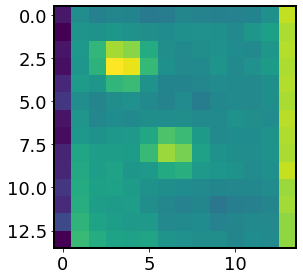

In [9]:
# Quick plot the continuum image now the NaN borders removed 
fig = plt.figure()
plt.imshow(cont_img.value)
plt.tight_layout()
plt.show()

INFO:astropy:Auto-setting vmin to -1.149e-18
INFO:astropy:Auto-setting vmax to  1.301e-19


INFO: Auto-setting vmin to -1.149e-18 [aplpy.core]
INFO: Auto-setting vmax to  1.301e-19 [aplpy.core]


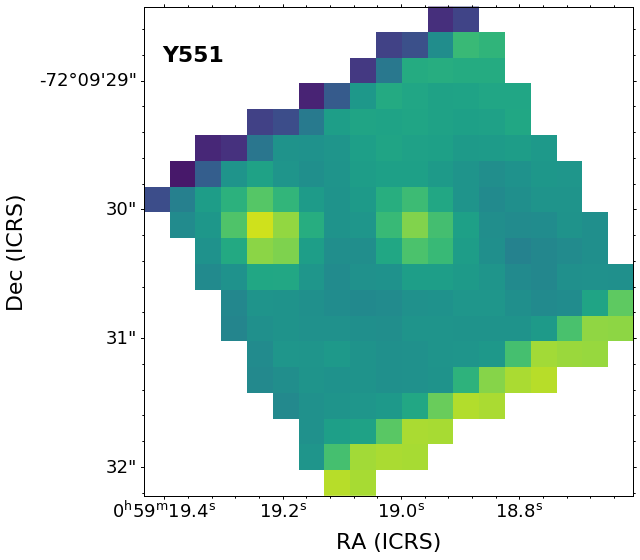

In [10]:
#Plot the continuum in WCS and save the file 
F = aplpy.FITSFigure(cont_img.hdu, north=True)
F.show_colorscale()
F.add_label(0.1, 0.9, name, relative=True, size=22, weight='bold')
F.axis_labels.set_font(size=22) #, weight='bold')
F.tick_labels.set_font(size=18, stretch='condensed')
F.save(outdir_Contimg+"_"+name+".pdf", dpi=300)        
#F.close()

## Now to detect the point source in the datacube and extract and plot the spectra for each source

**Developer note** Finding a way to stremline the process of detecting sources within a data cube and extracting their spectra would be extreamly valuable. For data cubes like the JWST/MIRI MRS infomation on the point-souces in the FOV and also obtaining a source subtracted data cube will be necessary (See the `PampelMuse` software for an example on how spectral extraction is implemented for near-IR data cubes like MUSE). Note these backgrounds of diffuse emission can be quite complex. On these source extracted data cubes (see `SUBTRES` in `PampelMuse`) I would like to produce moment maps (https://casa.nrao.edu/Release3.4.0/docs/UserMan/UserManse41.html) and Position-Velocity (PV) diagrams (https://casa.nrao.edu/Release4.1.0/doc/UserMan/UserManse42.html). 

### 1) Use `Photutils` to detect stars/point sources in the contimium image

The first step of the analysis is to identify those sources for which it is feasible to extract spectra from the IFU data. Idealy we can estimate the signal-to-noise ratio (S/N) for all sources in the cube, do a number of checks to determine the status of every source and loop through these (brightest first) to extract the spectra. 

### 2) Extract the spectra from the datacube using `SpectralCube`

**Note** There are multiple ways of extracting spectra from datacubes. The simplest is slice the cube along a single pixel but this is not ideal for point sources which should cover mutiple pixels. 
Here I use *Aperture Extraction*. 

- The flux from each point source was obtained via a circular aperture. This requires you to mask the data, and make a circular mask and a maskedsubcube.

- A background measured using a square/rectangular aperture sliced in pixel coordinates to produce a sub-cube.

- A annulus surrounding the point source to measure the local background. 

- Using predefined regions from DS9 etc. to create a mask [`Not used here`].

*If have a small number of data cubes selecting the source extraction region and background region manually using `cubeviz` would be useful here.*

Mathematical operation e.g. `max, mean, sum, median, std` should then be applied to the region in the apeture.  

Below I show a few diffrent options from the simple to the complex, which takes into account the background emission within the data cube. Taking into account the background may not always be the prefered method but the option should always be available when using an aperture extraction.  

#### Steps to find the background

1) Define a background region either as an annulus or as a rectangle away from the source

2) Find the median of all the background pixels to account for variations 

3) Find number of pixels in background and number of pixels in the point source aperture

4) Find the sum of all the pixels in the  point source aperture

5) Correct for background using the sum star flux minus median of backroung * pixles in star aperture



**Advanced Developer Note** Using Aperture Extraction to obtain the spectra for each source in the data cube is still very simplistic. It should be noted that the MIRI apeture changes as a function of wavelength, the steps above do not account for this. 
A good example of software that looks at extracting point sources from datacubes is: `PampelMuse`, by Sebastian Kamann. 
https://gitlab.gwdg.de/skamann/pampelmuse; https://ui.adsabs.harvard.edu/abs/2013A%26A...549A..71K/abstract

An `optimal spectrum extraction` procedure would take into account the varing PSF through the cube, to produce an accurate spectra with the maximum possible signal-to-noise ratio. This weights the extracted data by the S/N of each pixel (Horne 1986) and would be ideal for when there is a complex background or for extracting spatially-blended source. For small cubes its best to fit a PSF profile to all resolved sources simultaneously, but this might not be possible in larger data sets.    

**Advanced Developer Note 2** In dense fields like globular clusters, with a significant number of unresolved sources or in emmbeded star-forming clusters, a more advanced treatment of the background would be necessary. For instance using a homogeneous grid across the field of view with permaeters controling the bin size would be ideal. If a variable backgorund is not accounted for in a PSF extraction systematic residuals in the data would be present where background is over or underestimated.    



## Detect, extract and plot 1D spectrum of each source in the cube 

### First automaticaly identify all the point sources in the cube using `photutils`

In [11]:
# Make an array to store results of the source detection within the data cube
name_val = []
source_val = []
ra_val =[]
dec_val =[]

In [12]:
# Crop out Edges and take absolute value of the continium image
cont_img = cont_img[1:13, 1:13]  
#cont_img = abs(cont_img)

# Find the background in the collapsed datacube
mean, median, std = sigma_clipped_stats(cont_img.value, sigma=2.0)

# Get a list of sources using a dedicated aource detection algorithm
daofind = DAOStarFinder(fwhm=2.0, threshold=3.*std)      # Find sources at least 3* background (typically)
sources = daofind(cont_img.value - median) 
print("\n  Number of sources in field: ", len(sources))


  Number of sources in field:  2


### If point sources are present in the cube extract and plot the spectrum of each source

#### In the cell below we:

1) Extract a spectra for each detected object using aperture photometry, and a circular masked region.

2) Make an estimate of the background in the datacube using both: an annulus arround each source and a box region away from the source - this box is hard coded and not ideal for large datasets of mutiple cubes.   

3) Generate a background corrected spectrum.

4) Plots the spectra and its various background corrected versions. 

5) Convert the spectra into Jy.

6) Write each of the spectra to a file. (They could be put into a `specutils` `Spectrum1D` object at this stage but I have not done this here.) This file is loaded by all other routines to do analysis on the data. 


 id xcentroid ycentroid sharpness  ... sky      peak        flux      mag    
--- --------- --------- ---------- ... --- ------------- --------- ----------
  1 2.3734571 1.7177399 0.62142129 ...   0 5.5538106e-19 5.2739665 -1.8053434
  2 5.3369846 6.8329156 0.66676136 ...   0 4.1796922e-19 3.8700278 -1.4692852

00h59m19.2286s -72d09m30.1487s


/Users/ojones/anaconda3/envs/astro36/lib/python3.6/site-packages/spectral_cube/spectral_cube.py:246: UserWarning: Could not parse beam information from header.  Exception was: NoBeamException('No BMAJ found and does not appear to be a CASA/AIPS header.',)
  "  Exception was: {0}".format(ex.__repr__()))


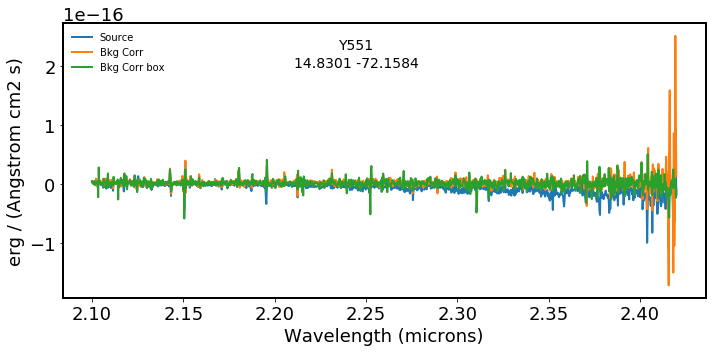

00h59m18.9713s -72d09m30.1505s


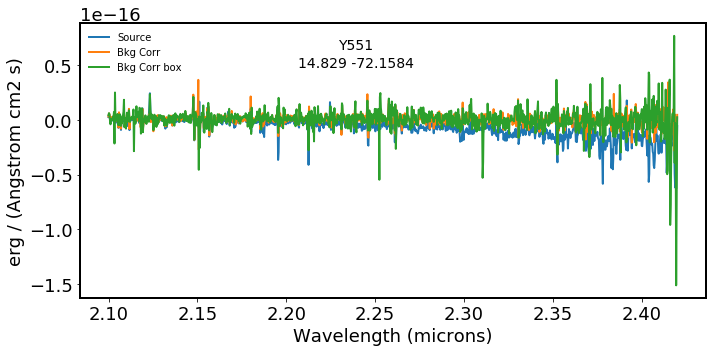

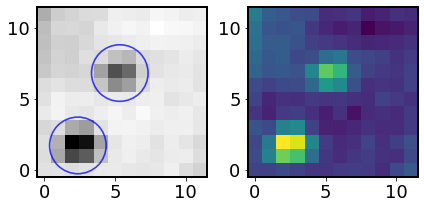

In [13]:
if len(sources) > 0:
    print()            
    for col in sources.colnames:    
        sources[col].info.format = '%.8g'  # for consistent table output

    print(sources)                  

    # From the list of sources in the field get their RA and DEC
    print()
    positions = Table([sources['xcentroid'], sources['ycentroid']])                # Table of positions in pixels
    w = WCS(cont_img.header)                                                       # Instantiate WCS object
    radec_lst  = w.pixel_to_world(sources['xcentroid'], sources['ycentroid'])      # Convert to RA and Dec in ICRS
    
    #-----------------------------------------------------  
    # We are now entering a loop which does mutiple processing steps on each point source detected in the cube
    for countS, _ in enumerate(sources):
        print(radec_lst[countS].to_string('hmsdms'))                  # Print the RA and Dec in hms dms values        
        name_val.append(name)
        source_val.append(countS)
        ra_val.append(radec_lst[countS].ra.deg)
        dec_val.append(radec_lst[countS].dec.deg)
        
        #-----------------------------------------------------           
        ## Aperture Extract spectrum of point source - using a cirular aperture            

        # Size of frame 
        ysize_pix = cmin.shape[1]
        xsize_pix = cmin.shape[2]

        # Set up some centroid pixel for the source 
        ycent_pix = sources['ycentroid'][countS]
        xcent_pix = sources['xcentroid'][countS]

        # Make an aperture radius for source - if made into a function this value should not be hardcoded
        apertureRad_pix = 2

        # Make a masked array for the apeture
        yy, xx = np.indices([ysize_pix,xsize_pix], dtype='float')    # Check ycentpix, xcentpix are in correct order 
        radius = ((yy-ycent_pix)**2 + (xx-xcent_pix)**2)**0.5        # Make a circle in the frame

        mask = radius <= apertureRad_pix                # Select pixels within the aperture radius
        maskedcube = cmin.with_mask(mask)               # Make a masked cube
        pixInAp = np.count_nonzero(mask == 1)           # Pixels in apeture

        spectrum = maskedcube.sum(axis=(1,2))           # Extract the spectrum from only the annulus - use sum
        noisespectrum = maskedcube.std(axis=(1, 2))     # Extract the noise spectrum for the source 

        # Measure a spectrum from the background -> Use an annulus arround the source - if made into a function these values should not be hardcoded
        an_mask = (radius > apertureRad_pix + 1) & (radius <= apertureRad_pix + 2)   # Select pixels within an anulus
        an_maskedcube = cmin.with_mask(an_mask)                                      # Make a masked cube

        # Extract the background spectrum from only the anulus
        bkg_spectrum = an_maskedcube.median(axis=(1,2))          

        # Background corrected spectrum - annulus
        correctedSp = spectrum - (bkg_spectrum * pixInAp)

        # Try measuring a spectrum from the background -> Use a box away from source 
        # Note this region is hardcoded so not optimized for each data cube - this should be improved.
        bkgcube = cmin[:, 1:3, 10:13]  
        bkgbox_spectrum = bkgcube.median(axis=(1,2)) 
        bkg_img = bkgcube.median(axis=0)

        # Background corrected spectrum - box
        correctedSp_box = spectrum - (bkgbox_spectrum * pixInAp)
                
        #-----------------------------------------------------               
        # Plot the spectrum extracted from cirular aperture via: a sum extraction 
        
        fig = plt.figure(figsize=(10,5))
        plt.plot(maskedcube.spectral_axis.value,spectrum.value, label='Source')        # Source spectrum 
        plt.plot(maskedcube.spectral_axis.value,correctedSp.value, label='Bkg Corr')   # Bkg corrected spectrum                 
        plt.plot(maskedcube.spectral_axis.value,correctedSp_box.value, label='Bkg Corr box')  # Bkg corrected spectrum                 

        plt.xlabel('Wavelength (microns)')
        plt.ylabel('erg / (Angstrom cm2 s)') #plt.ylabel(spectrum.unit)

        plt.gcf().text(0.5, 0.85,name, fontsize=14, ha='center')
        plt.gcf().text(0.5, 0.80,radec_lst[countS].to_string('decimal'), ha='center', fontsize=14)

        plt.legend(frameon=False, fontsize='medium')
        plt.tight_layout()
        plt.show()
        plt.close()
        
        #-----------------------------------------------------  
        # Convert flux from erg / (Angstrom cm2 s) to Jy 
        
        spectrumJy = spectrum.to(u.Jy, equivalencies=u.spectral_density(maskedcube.spectral_axis)) 
        correctedSp_Jy = correctedSp.to(u.Jy, equivalencies=u.spectral_density(maskedcube.spectral_axis))
        correctedSp_box_Jy = correctedSp_box.to(u.Jy, equivalencies=u.spectral_density(maskedcube.spectral_axis))
        noiseSp_Jy   = noisespectrum.to(u.Jy, equivalencies=u.spectral_density(maskedcube.spectral_axis))

        #-----------------------------------------------------
        # Save each extracted spectrum to a file

        # Set an output name
        specOutname = name+"_"+str(countS)+"_"+"spec"
        #print(specOutname)

        # Make output table 
        specdataTab = Table([maskedcube.spectral_axis, correctedSp_Jy, noiseSp_Jy, spectrumJy, correctedSp_box_Jy], 
                            names=['wave_mum', 'cSpec_Jy', 'errFl_Jy', 'spec_Jy', 'cSpec_box_Jy'])   

        # Write the file - it might be better to store all the extracted spectra in individual FITS files
        ascii.write(specdataTab, outdir_spectra+specOutname+".csv", format='csv', overwrite=True)   # No units or metadata exported

    #-----------------------------------------------------
    # Do apeture photometry on the sources - Only if using sum of image

    # Take list of star possitions from DAOFIND use this to define an appeture
    if len(sources) == 2:                         # To overcome in array order 
        sources = vstack([sources, sources])             
        positions_pix = (sources['xcentroid'], sources['ycentroid'])
    else:
        positions_pix = (sources['xcentroid'], sources['ycentroid'])

    apertures = CircularAperture(positions_pix, r=2.)   # Take the apeture radius to be 1.5 pixels
    
    #-----------------------------------------------------
    # As a check to make sure all obvious point sources have been identified plot the cube with the NaN borders removed and overplot the apetures for the extracted sources
    fig = plt.figure()            

    plt.subplot(1, 2, 1)
    plt.imshow(cont_img.value, cmap='Greys', origin='lower')
    apertures.plot(color='blue', lw=1.5, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.imshow(cont_img.value, origin='lower')

    plt.tight_layout()
    plt.show()
    plt.close()

else:  
    # Plot the cube with the NaN borders removed 
    fig = plt.figure()
    plt.imshow(cont_img.value, origin='lower')
    plt.tight_layout()
    plt.show()
    plt.close()

In [14]:
# Make table of extracted sources
sourceExtSpecTab = Table([name_val, source_val, ra_val, dec_val], 
                      names=("name", "source_no", "ra", "dec"))
print(sourceExtSpecTab)   

# Write table of extacted spectra for bookkeeping
#ascii.write(sourceExtSpecTab, outdir_spectra+"YSOsourcesSpec_list.csv", format='csv', overwrite=True) 

name source_no         ra                dec        
---- --------- ------------------ ------------------
Y551         0 14.830119062034905 -72.15837463495436
Y551         1 14.829047135765496 -72.15837513138561


##  Data analysis - on the extracted spectra 
With the present lack of JWST flight data, we instead use the SWS spectra of an dusty AGB star, a cool M-star and the spectra of a YSO we extracted in the stages above.  

In [15]:
# To deal with 1D spectrum
from specutils import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum, fit_continuum, find_lines_threshold,  find_lines_derivative, estimate_line_parameters, fit_lines
from specutils.manipulation import noise_region_uncertainty, box_smooth, extract_region, gaussian_smooth, SplineInterpolatedResampler
from specutils.analysis import snr, line_flux, centroid, equivalent_width
from specutils.spectra import SpectralRegion

from astropy.nddata import StdDevUncertainty
from astropy.modeling import models

# For Model atmospheres
#import pysynphot as S

# To fit a curve to the data
from scipy.optimize import curve_fit

In [16]:
# Set the paths to the spectral data extracted from the datacube above
dusty_AGB_spec_file = '/Users/ojones/Science/MIRI_project_wk/specToolDev/63702662.txt'
yso_spec_file = '/Users/ojones/Desktop/YSO_NGC346/VLT_results/spectra/highQualSpec/K_Band_Y556_A_spec.csv'

### Work on the dusty AGB spectra from SWS - use `specutils`

In [17]:
spectra_file = dusty_AGB_spec_file

In [18]:
# Read in the spectra - as saved as text files (easier for idl use) & do some housekeeping
data = ascii.read(spectra_file)

if data.colnames[0] == 'col1':
    data['col1'].name = 'wave_mum'
    data['col2'].name = 'cSpec_Jy'            
    data['col3'].name = 'errFl_Jy'         

wav = data['wave_mum'] * u.micron  # Wavelength: microns
fl  = data['cSpec_Jy'] * u.Jy      # Fnu:  Jy
efl  = data['errFl_Jy'] * u.Jy     # Error flux: Jy

spec = Spectrum1D(spectral_axis=wav, flux=fl, uncertainty=StdDevUncertainty(efl))  # Make a 1D spectrum object

**Note** Reading in a spectra comprised of multiple spectral components this file may have a spectral order column. In many instances these orders are not correcly stiched together due to issues with background and flux calaibration. A spectral file with an order column that can read into the `Spectrum1D` is necessary to do corrections and scaling on each segment indivisually to fix the jumps between the spectra.  

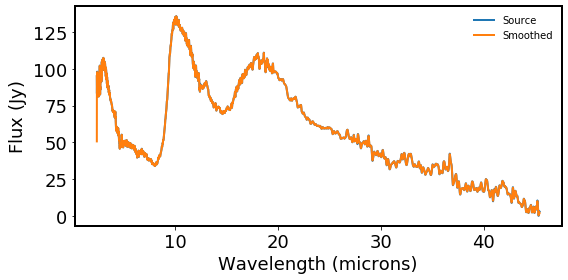

In [19]:
# Apply a 7 pixel boxcar smoothing to the spectrum 
spec_bsmooth = box_smooth(spec, width=5)   

# Plot the spectrum & smoothed spectrum to inspect features 
fig = plt.figure(figsize=(8,4))
plt.plot(spec.spectral_axis, spec.flux, label='Source')                 # Source spectrum 
plt.plot(spec.spectral_axis, spec_bsmooth.flux, label='Smoothed')       # Smoothed spectrum 
plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))

plt.legend(frameon=False, fontsize='medium')
plt.tight_layout()
plt.show()
plt.close()

### Fit a continiumn - find the best-fitting template (stellar photosphere model or blackbody)

**Note** - Here I am *trying* to use a set of Phoenix Models - but cant get that to work. Think `template_comparison` may be a good function here to work with the Phoenix Models which have been setup to  interface with `pysynphot`. It needs a list of templates, but im not sure how use the interface for this. 

For now switching to a blackbody.

- For AGB stars with a photosphere component fit a stellar photosphere model or a blackbody to short wavelength end of the spectra

In [20]:
def blackbody_Fnu(lam, T, A):
    """ Blackbody as a function of wavelength (um) and temperature (K).
        Function returns the Planck function in f_nu units
        # [Y Jy] = 1.0E+23 * [X erg/cm^2/s/Hz]  = 10E+26  [X Watts/m^2/Hz]         
    """
    from scipy.constants import h,k,c
    lam = 1e-6 * lam                                              # convert to metres
    bb_nu = 2*h*c / (lam**3 * (np.exp(h*c / (lam*k*T)) - 1))      # units of W/m^2/Hz/Steradian ; f_nu units
    return A*bb_nu

In [21]:
# Only want to fit to a small wavelength range at the start of the spectra
phot_fit_region = [3.0, 9.4]  # Microns

# Trim the specrum to the region showing a stellar photosphere
sub_region_phot = SpectralRegion([(phot_fit_region[0], phot_fit_region[1])]*u.micron)
sub_spectrum_phot = extract_region(spec, sub_region_phot)

In [22]:
# fit BB to the data
def phot_fn(wa, T1, A):
    return blackbody_Fnu(wa, T1, A) 

popt, pcov = curve_fit(phot_fn, sub_spectrum_phot.spectral_axis.value, sub_spectrum_phot.flux.value, p0=(3000, 10000), sigma=sub_spectrum_phot.uncertainty.quantity)

# get the best fitting parameter value and their 1 sigma errors
bestT1, bestA1 = popt
sigmaT1, sigmaA1 = np.sqrt(np.diag(pcov))

ybest = blackbody_Fnu(spec.spectral_axis.value, bestT1, bestA1) 

print ('Parameters of best-fitting model:')
print ('  T1 = %.2f +/- %.2f' % (bestT1, sigmaT1))

degrees_of_freedom = len(sub_spectrum_phot.spectral_axis.value) - 2
resid = (sub_spectrum_phot.flux.value - phot_fn(sub_spectrum_phot.spectral_axis.value, *popt)) / sub_spectrum_phot.uncertainty.quantity
chisq = np.dot(resid, resid)

print (degrees_of_freedom, 'dof')
print ('chi squared %.2f' % chisq)
print ('nchi2 %.2f' % (chisq / degrees_of_freedom))

Parameters of best-fitting model:
  T1 = 2361.46 +/- 20.80
4609 dof
chi squared 3818398.83
nchi2 828.47


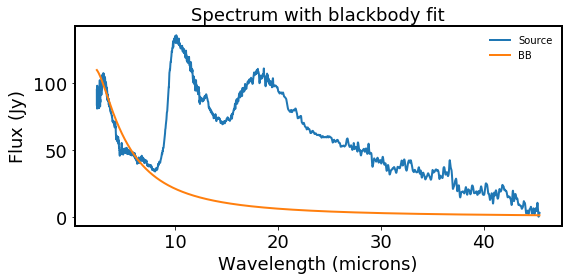

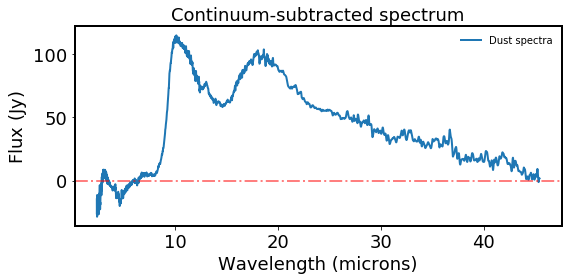

In [23]:
# Plot the spectrum & the model fit to the short wavelenght region of the data, where dust has a mininmal effect. 
fig = plt.figure(figsize=(8,4))
plt.plot(spec.spectral_axis, spec.flux, label='Source')                 # Source spectrum 
plt.plot(spec.spectral_axis, ybest, label='BB')                         # BB
plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
plt.title("Spectrum with blackbody fit")
plt.legend(frameon=False, fontsize='medium')
plt.tight_layout()
plt.show()
plt.close()

# Now subtract the BB and plot the underlying dust continiumn
fig = plt.figure(figsize=(8,4))
plt.plot(spec.spectral_axis, spec.flux.value-ybest, label='Dust spectra')               # Dust spectrum 
plt.axhline(0, color='r', linestyle='dashdot', alpha=0.5)                               # hline = 0
plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
plt.title("Continuum-subtracted spectrum")
plt.legend(frameon=False, fontsize='medium')
plt.tight_layout()
plt.show()
plt.close()

### Now have the dust continiumn want to look for features and measure their propeties. 

Want to find:
- Equivalent width
- Equivalent flux
- Optical depth
- Centroids = wavelength with half the flux on either side

First fit a spline to the continiumn subtracted spectra. 

*As an example lets focus on the amorphous silicate 10 micron region.* 

**Note**
This seems like a long winded way to do this. Is there a simpler approach?

> For instance a tool that takes four wavelengths, fits a line using the data from  lam0 to lam1 and lam2 to lam3, then passes the continuum-subtracted  spectrum for line integration from lam1 to lam2 with error propagation is needed several times for dust features. But with the current spectra1d framework this takes many steps to write manually and is beyond tedious after doing this for 2 features let alone 20+.  Similar framework is also needed for the integrated line centroid with uncertainty, and the extracted equivalent width. 

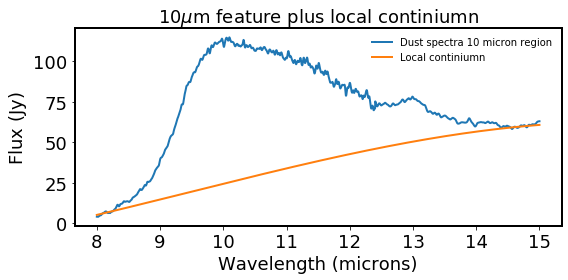

In [24]:
# Fit a local contimium between the flux densities at 8.0 $\mu $m to 8.1 $\mu $m and 12.9 $\mu $m to 13.0 $\mu
# Fit a spline to the 10 micron feature to isolate it 

bbsub_spectra = spec-ybest                                         # Continiumn subtracted spectra

# Extract the line from the orginal spectrum and refit a contimiumn (excluding the line itself)
sw_line = 8.0
lw_line = 15.0

line_reg_10 = SpectralRegion([(sw_line*u.um,lw_line*u.um)]) # 10 micron region 
line_spec =  extract_region(bbsub_spectra, line_reg_10)     # line spectrum

# Fit a local continiumn
lgl_fit = fit_generic_continuum(line_spec,
                                exclude_regions = SpectralRegion(
                                             [8.1]*u.um, 
                                             [14.9]*u.um))  # 
line_y_continuum = lgl_fit(line_spec.spectral_axis)  # Determine Y values of the line contimiumn

#-----------------------------------------------------------------
# Generate a continuum subtracted and continuum normalised spectra
line_spec_norm =  line_spec / line_y_continuum
line_spec_consub = line_spec - line_y_continuum

#-----------------------------------------------------------------
# Plot the spectrum & smoothed spectrum to inspect features 
fig = plt.figure(figsize=(8,4))
plt.plot(line_spec.spectral_axis, line_spec.flux.value, label='Dust spectra 10 micron region')                 # Dust spectrum 

plt.plot(line_spec.spectral_axis, line_y_continuum, label='Local continiumn')       # Ft Continiumn. 
plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
plt.title("10$\mu$m feature plus local continiumn")
plt.legend(frameon=False, fontsize='medium')
plt.tight_layout()
plt.show()
plt.close()

In [25]:
# Calculate the Line flux; Line Centroid; Equivalent width - NOTE where do errors fall in this???

# NB need to convert spectral data from F_nu units to F_lambda units 
#line_spec_consub = line_spec_consub.new_flux_unit(u.W * u.m**-2 * u.micron**-1, equivalencies=u.spectral_density(line_spec_consub.spectral_axis))

line_centroid = centroid(line_spec_consub, SpectralRegion(sw_line*u.um, lw_line*u.um))    # Line centroid     
print("Line_centroid: {:.6} ".format(line_centroid))

line_flux_val = line_flux(line_spec_consub, SpectralRegion(sw_line*u.um, lw_line*u.um))    # Line flux 
print("Integrated line_flux: {:.6} ".format(line_flux_val))

equivalent_width_val = equivalent_width(line_spec_norm)        # Equivalent width - This seems strange and the value wrong
print("Equivalent width: {:.6} ".format(equivalent_width_val))  

Line_centroid: 10.7243 micron 
Integrated line_flux: 249.75 Jy micron 
Equivalent width: -8.85904 micron 


**Developer note** Line values in Jy micron are not used in papers to report line flux - this should be in W/m^2. But I have been unable to get a unit conversion to work within the `specutils` framework. The flux of the line should be converted to F_lambda units prior to the line flux integration, using the `new_flux_unit` methods in the `Spectrum1D` this results in the `line_flux` code breaking, I think due to the error units not being converted when the flux units were. Implementing a simple way to convert the flux and associate error to other units seems necessary. 

In [26]:
# Compute the optical depth of the 10 \mum feature
tau = -(np.log(line_spec.flux.value/line_y_continuum.value))    
#optdepth_spec = Spectrum1D(spectral_axis=line_spec.spectral_axis, flux=tau) 
        

**Developer note** Trying to put optical depth into a Spectrum1D object results in an error as no units. But the optical depth is unit-less. Have hacked the system below to say has units of Jy to continue using the `Spectrum1D` class.

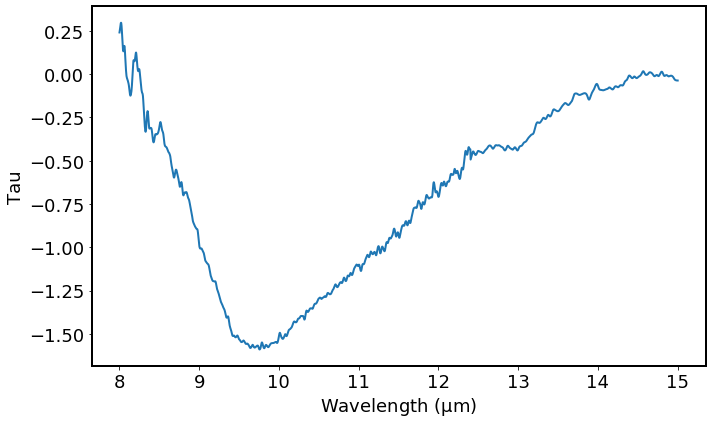

In [27]:
optdepth_spec = Spectrum1D(spectral_axis=line_spec.spectral_axis, flux=tau*u.Jy) # This is scientificaly incorrect

# Plot the optical depth of the 10 micorn region vs wavelength 
fig = plt.figure(figsize=(10,6))
plt.plot(optdepth_spec.spectral_axis, optdepth_spec.flux)
plt.xlabel("Wavelength ({:latex})".format(spec.spectral_axis.unit))
plt.ylabel('Tau') 
plt.tight_layout()
plt.show()
plt.close()

**Note** At this point repeat *all* the long steps above to isolating features for the one at at approx 13.3 microns. 

In [28]:
optdepth_spec = Spectrum1D(spectral_axis=line_spec.spectral_axis, flux=tau) 

ValueError: Flux must be a `Quantity` object.

#### Now try looking for low crystalline silicate features in the spectra. 

In [29]:
## Lets start by looking for low contrast crystalline sillicate features at 23, 28, 33 microns.

bbsub_spectra = spec-ybest  # photosphere continiumn subtracted spectra

spline_points = [20.0, 21.3, 22.0, 24.4, 25.5, 33.8, 35.9] * u.nm  # Spline points 

fluxc_resample = SplineInterpolatedResampler()    # Not sure why this stage is needed but is done in example

spline_spec = fluxc_resample(bbsub_spectra, spline_points) # Generate a spline fit to the dust continiumn

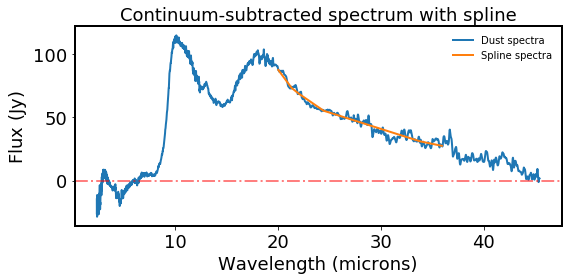

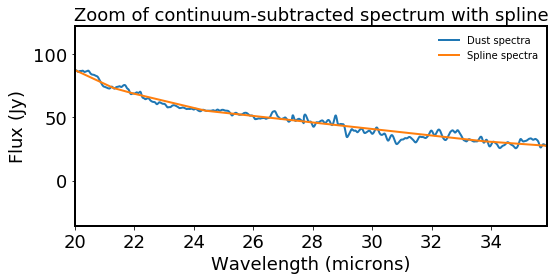

In [30]:
# Plot the underlying dust continiumn and spline fit 
fig = plt.figure(figsize=(8,4))
plt.plot(bbsub_spectra.spectral_axis, bbsub_spectra.flux.value, label='Dust spectra')       # Dust spectrum 
plt.plot(spline_spec.spectral_axis, spline_spec.flux.value, label='Spline spectra')         # Spline spectrum 

plt.axhline(0, color='r', linestyle='dashdot', alpha=0.5)

plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
plt.title("Continuum-subtracted spectrum with spline")
plt.legend(frameon=False, fontsize='medium')
plt.tight_layout()
plt.show()
plt.close()

# Plot the underlying dust continiumn and spline fit 
fig = plt.figure(figsize=(8,4))
plt.plot(bbsub_spectra.spectral_axis, bbsub_spectra.flux.value, label='Dust spectra')       # Dust spectrum 
plt.plot(spline_spec.spectral_axis, spline_spec.flux.value, label='Spline spectra')         # Spline spectrum 

plt.xlim(spline_points[0].value, spline_points[-1].value)

plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
plt.title("Zoom of continuum-subtracted spectrum with spline")
plt.legend(frameon=False, fontsize='medium')
plt.tight_layout()
plt.show()
plt.close()


# # Plot spline subtracted spectra
# fig = plt.figure(figsize=(8,4))
# plt.plot(spline_spec.spectral_axis, bbsub_spectra.flux.value-spline_spec.flux.value, label='Spline sub spectra')       # Dust spectrum 

# plt.xlim(spline_points[0].value, spline_points[-1].value)

# plt.xlabel('Wavelength (microns)')
# plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
# plt.title("Spline-subtracted spectrum with spline")
# plt.legend(frameon=False, fontsize='medium')
# plt.tight_layout()
# plt.show()
# plt.close()

**Developer note** By fitting a spline to a sub region the spectral shapes are no longer the same. ` bbsub_spectra.flux.value-spline_spec.flux.value` now brakes. Would need to trim the spectrum to the spline size to start looking closely for low contrast dust features and again measure their propeties (see above). Some nice wrapper to stop repeating the same steps over and over would be nice.  

### Switiching to the spectra extracted from the KMOS data cube in part one. Work on the YSO spectra - use `specutils`

This spectra is relativly dust free, flat, and has atomic emisison lines  `specutils` has lots of functionality here that can help. 

In [31]:
spectra_file = yso_spec_file

In [32]:
# Read in the spectra - as saved as text files (easier for idl use) & do some housekeeping
data = ascii.read(spectra_file)

if data.colnames[0] == 'col1':
    data['col1'].name = 'wave_mum'
    data['col2'].name = 'cSpec_Jy'            
    data['col3'].name = 'errFl_Jy'

    data['spec_Jy'] = data['cSpec_Jy']
    data['cSpec_box_Jy'] = data['cSpec_Jy']            

wav = data['wave_mum'] * u.micron  # Wavelength: microns
fl  = data['cSpec_Jy'] * u.Jy      # Background corrected flux: microns
efl  = data['errFl_Jy'] * u.Jy     # Error flux: microns calculated from standard deviation

fl_wbkg = data['cSpec_Jy'] * u.Jy   # Non-background corrected flux: microns
fl_cbox = data['cSpec_Jy'] * u.Jy   # Background corrected flux using box: microns 

spec = Spectrum1D(spectral_axis=wav, flux=fl, uncertainty=StdDevUncertainty(efl.value))  # Make a 1D spectrum object


**TODO**

Resample the spectrum to a lower wavelenth bin - preserving the flux to increse the S/N?


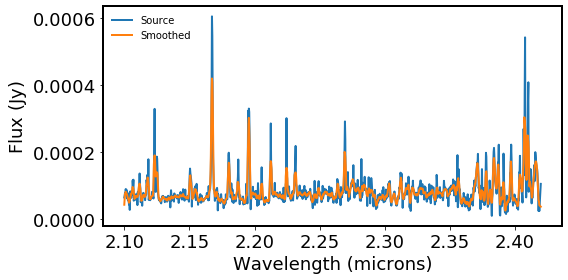

In [33]:
# Apply a 7 pixel boxcar smoothing to the spectrum 
spec_bsmooth = box_smooth(spec, width=5)   

# Plot the spectrum & smoothed spectrum to inspect features 
fig = plt.figure(figsize=(8,4))
plt.plot(spec.spectral_axis, spec.flux, label='Source')                 # Source spectrum 
plt.plot(spec.spectral_axis, spec_bsmooth.flux, label='Smoothed')       # Smoothed spectrum 
plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))

plt.legend(frameon=False, fontsize='medium')
plt.tight_layout()
plt.show()
plt.close()

In [34]:
# Define good wavelength ranges for each grating from which to make the 1D spectra
K_range  = [2.1,2.415]    # microns    

# Trim the specrum removing junk at the ends
sub_region = SpectralRegion([(K_range[0], K_range[1])]*u.micron)
sub_spectrum = extract_region(spec, sub_region)
spec = sub_spectrum

In [35]:
# Define regions in the spectrum without line emmsion from which to estimate the noise [UPDATE]
K_noise_ra  = [2.25,2.30]    # microns  

# Estimate uncertainty from the spectrum itself.    
noise_region = SpectralRegion([(K_noise_ra[0], K_noise_ra[1])]*u.micron)
spec_w_unc = noise_region_uncertainty(spec, noise_region)

# Calculate the S/N of the spectrum
sig2noise = np.round(snr(spec), 2)
#sig2noise_w_unc = np.round(snr(spec_w_unc), 2)

### Fit a continuum

**Developer note** fitting a spline function is somthing I use regularly in the data analysis of dust features in spectra. 

Idealy a function as simple as: 

> spline = Spectrum1d.fitSpline(splinepoints)  

where spline points are an array of wavelength values corrsponding to points on the spectral_axis. More advances these points could be chosen via a GUI and interactivly clicking on a spectral plot.


- There are a few methods for flat (dust free) specra. Experimenting below with the options in specutils. 

In [36]:
# Calculate a continuum 
g1_fit      = fit_generic_continuum(spec_w_unc)          # Uses a Chebyshev1D model and leas Sq fit
y_continuum = g1_fit(spec_w_unc.spectral_axis)           # Determine Y values of the contimiumn

####################################
# OR for more controle:

# Set regions where lines are to avoid biasing the continium fit
to_exclude = [(2.35, 2.45)*u.micron, (2.15, 2.17)*u.micron]        # Define lines/regions to exclude
exclude_region = SpectralRegion(to_exclude)                        # Make a specutils region

continuum_model = fit_generic_continuum(spec_bsmooth, exclude_regions=exclude_region)    # Generate the contimiumn
#continuum_model = fit_continuum(spec_bsmooth, model=Chebyshev1D(10), fitter=LinearLSQFitter(), exclude_regions=exclude_region)

y_continuum_2 = continuum_model(spec_w_unc.spectral_axis)               # Put the second continiumn into 1d spectra object

# Generate a continuum subtracted and continuum normalised spectra - both needed for later analysis
spec_norm =  spec_w_unc / y_continuum
spec_consub = spec_w_unc - y_continuum

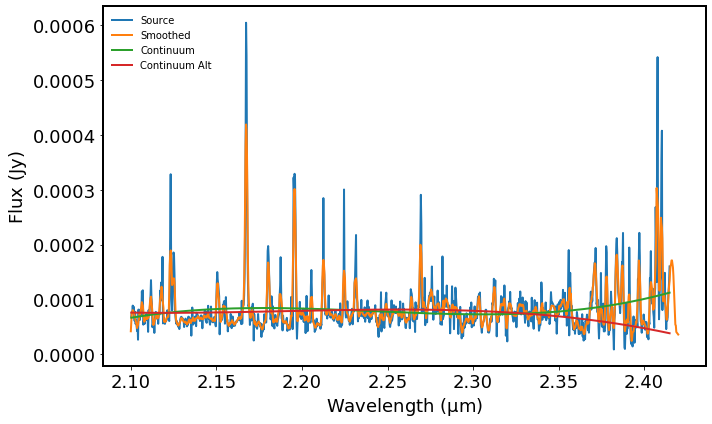

In [37]:
# Plot the continiumn and spectra
fig = plt.figure(figsize=(10,6))
plt.plot(spec.spectral_axis, spec.flux, label='Source')                         # Source spectrum 
plt.plot(spec_bsmooth.spectral_axis, spec_bsmooth.flux, label='Smoothed')       # Smoothed spectrum 
plt.plot(spec.spectral_axis, y_continuum, label='Continuum')                    # Contimiumn 
plt.plot(spec.spectral_axis, y_continuum_2, label='Continuum Alt')              # Contimiumn Alt


plt.xlabel("Wavelength ({:latex})".format(spec.spectral_axis.unit))
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))

plt.legend(frameon=False, fontsize='medium')
plt.tight_layout()
plt.show()
plt.close()

The plot of the continiumn above shows that estimated continium is too high. Need to work how to tweak. 

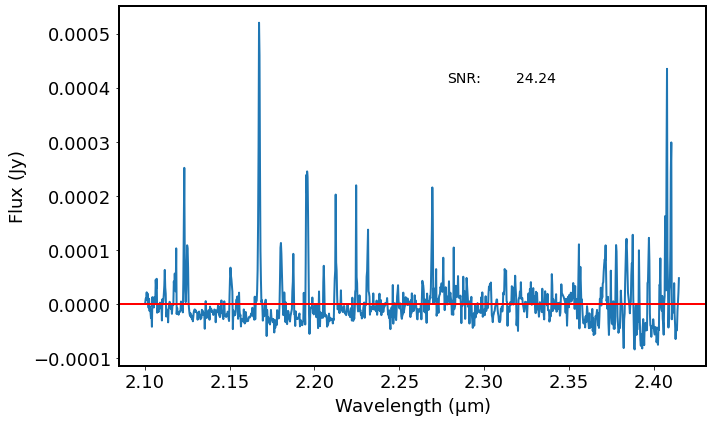

In [38]:
# Plot the contimum subtracted spectrum
fig = plt.figure(figsize=(10,6))
plt.plot(spec_consub.spectral_axis, spec_consub.flux)
plt.axhline(y=0.0, color='r', linestyle='-')

plt.xlabel("Wavelength ({:latex})".format(spec.spectral_axis.unit))
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))

plt.gcf().text(0.65, 0.80, "SNR:", fontsize=14, ha='center')        
plt.gcf().text(0.75, 0.80,sig2noise, fontsize=14, ha='center')         # S/N from read in spectra            

plt.tight_layout()
plt.show()
plt.close()


### Look for lines in the spectra

In [39]:
#Read in IR line lists
line_file = "/Users/ojones/Desktop/NGC_346_working/nearIR_linelist_long.csv"
line_data = ascii.read(line_file)

For robust line identification vs noise or other crap in spectra have had to comple own database of IR lines. It would be good to be able to pull data from other (more complete) databases rather than having to do this manualy (see ALMA tools).  


Line identification: catalogues: 

- Splatalogue:  http://www.cv.nrao.edu/php/splat/advanced.php
- Cologne Database for Molecular Spectroscopy: http://www.astro.uni-koeln.de/cdms/
- Jet Propulsion Laboratory: http://spec.jpl.nasa.gov/
- NIST Recommended Rest Frequencies http://physics.nist.gov/cgi-bin/micro/table5/start.pl

**Developer Note**

Some tool for line identification below shows structure in ALMA/CASA tools. 

Line id.: slsearch and splattotable

slsearch: searches in splatalogue the molecules/lines matching the selection. Prints results in the CASA log or writes a table:  

> slsearch(freqrange=[freq1,freq2], verbose=True)

> slsearch(outfile=’mylines.tbl', freqrange=[freq1,freq2])

> slsearch(tablename = ’mylines.tbl', freqrange = [freq1,freq2], species = [’mymolecule'], verbose=True)

splattotable: converts txt files in to CASA tables 

> splattotable(filenames = ['splatalogue.tsv'],               table = 'splatalogue.tbl')


In [40]:
# NOTE: when first looking for lines lower tollerance of the S/N to ~4 
# NOTE: also lower the find_lines_threshold(spec_consub, noise_factor=5)  from 5 to 3       

if sig2noise > 5:

    #-------------------------------------------------------------------------------------------------
    # Find emmsion and absorption lines in the continuum-subtracted spectra

    lines = find_lines_threshold(spec_consub, noise_factor=5) # Selects lines 5 x spectrum uncertainty

    if len(lines) >0:
        emissionlines = lines[lines['line_type'] == 'emission']   # Grab a list of the emission lines
        abslines = lines[lines['line_type'] == 'absorption']      # Grab a list of the absorption lines
        print("Number of emission lines found:", len(emissionlines))
    else:
        emissionlines = [0]
        print("No emission lines found!") 

Number of emission lines found: 9


### Now have a lot of lines that need to be looked at in detail - note often have mutiple sources as well so lots of loops ahead. 

Some tool to quickly cycle through the lines, show them identified on the spectra and a way to toggle how good the line idientification is would be handy. For now this has to be done manually and can be very time consuming.


- Tool for quickly calulating the area of the gausian would be handy 

#### In the cell below we:

1) Zoom in on the identified emission lines in the spectra. 

2) Fit a new local continuum for each line and subtract this.  

3) Estimate the line centroid using `estimate_line_parameters`  

4) Fit each line with a Gaussian to measure , amplitide, FWHM, Area, radial velocity.

5) Try and automatically identify the line using a database. 

6) Plot the Spectra the lines measured and the lines identified. 

/Users/ojones/anaconda3/envs/astro36/lib/python3.6/site-packages/astropy/table/row.py:81: FutureWarning: elementwise != comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() != other


The S/N of the line region is:   2.6
Integrated line flux trapesium integration:  9.54095e-20 W / m2 
Integrated line flux `line_flux` funtion: 1.84873e-07 Jy micron 
Log Integrated line flux -19.0204 W / m2


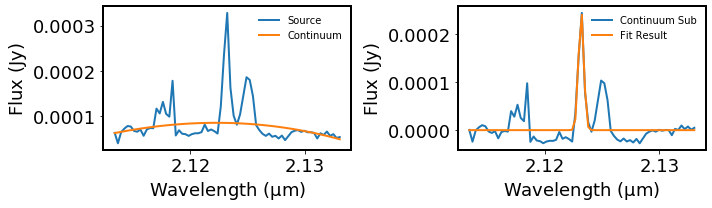

The S/N of the line region is:   2.92
Integrated line flux trapesium integration:  3.26695e-19 W / m2 
Integrated line flux `line_flux` funtion: 4.31506e-07 Jy micron 
Log Integrated line flux -18.4859 W / m2


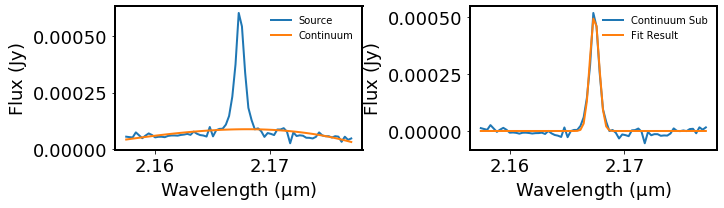

The S/N of the line region is:   2.82
Integrated line flux trapesium integration:  2.52266e-19 W / m2 
Integrated line flux `line_flux` funtion: 3.69933e-07 Jy micron 
Log Integrated line flux -18.5981 W / m2


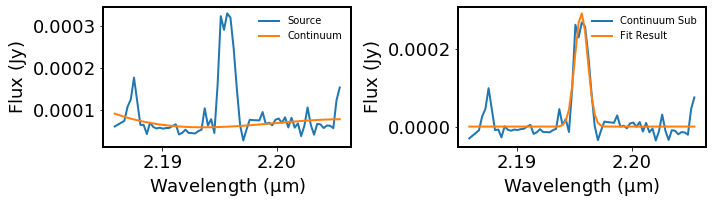

The S/N of the line region is:   2.42
Integrated line flux trapesium integration:  9.92849e-20 W / m2 
Integrated line flux `line_flux` funtion: 1.72459e-07 Jy micron 
Log Integrated line flux -19.0031 W / m2


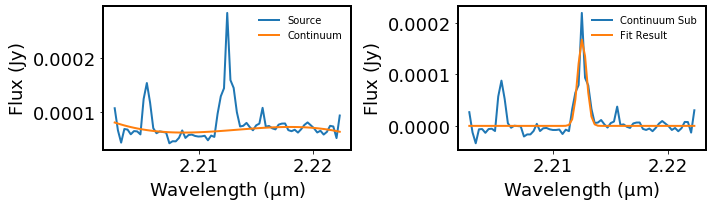

The S/N of the line region is:   2.56
Integrated line flux trapesium integration:  5.78826e-20 W / m2 
Integrated line flux `line_flux` funtion: 1.97276e-07 Jy micron 
Log Integrated line flux -19.2375 W / m2


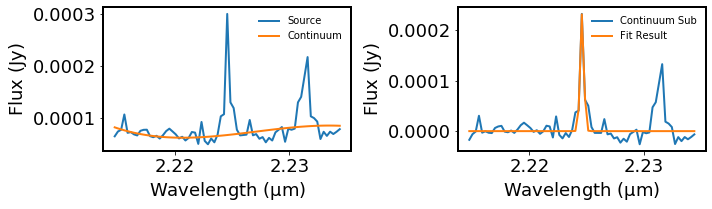

The S/N of the line region is:   2.89
Integrated line flux trapesium integration:  9.30498e-20 W / m2 
Integrated line flux `line_flux` funtion: 1.66524e-07 Jy micron 
Log Integrated line flux -19.0313 W / m2


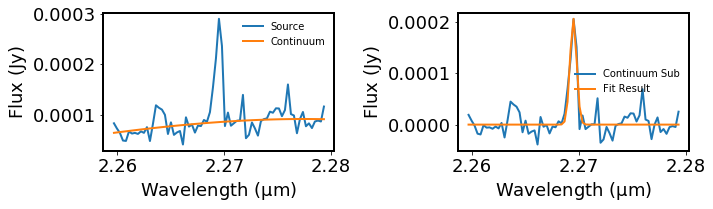

The S/N of the line region is:   3.74
Integrated line flux trapesium integration:  0.0 W / m2 
Integrated line flux `line_flux` funtion: -9.82086e-08 Jy micron 
Log Integrated line flux -inf W / m2


/Users/ojones/anaconda3/envs/astro36/lib/python3.6/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/ojones/anaconda3/envs/astro36/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log10


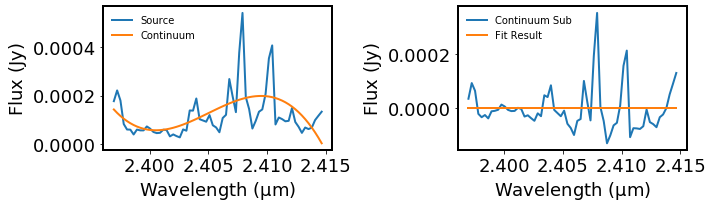

The S/N of the line region is:   3.65
Integrated line flux trapesium integration:  1.00232e-19 W / m2 
Integrated line flux `line_flux` funtion: 2.15772e-07 Jy micron 
Log Integrated line flux -18.999 W / m2


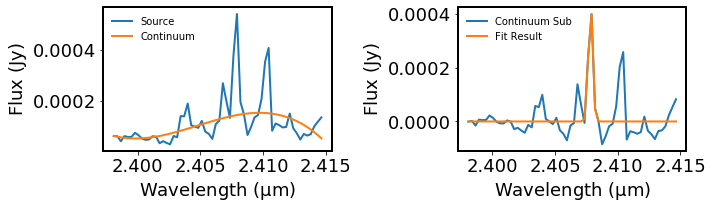

The S/N of the line region is:   3.98
Integrated line flux trapesium integration:  9.67514e-20 W / m2 
Integrated line flux `line_flux` funtion: 1.96386e-07 Jy micron 
Log Integrated line flux -19.0143 W / m2


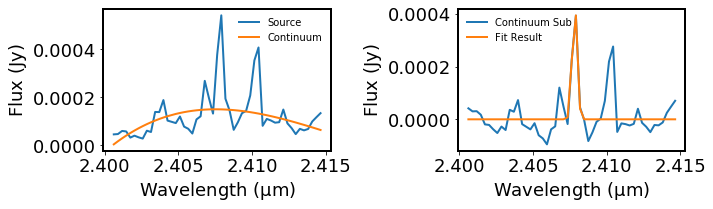

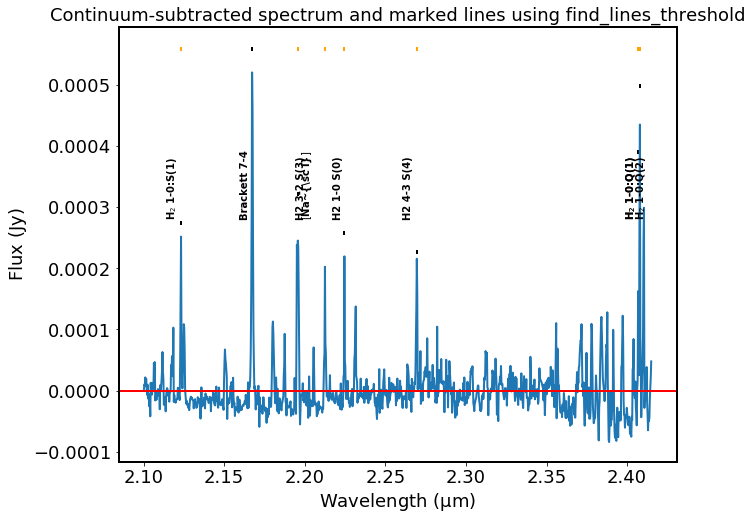

In [41]:
# Add columns to the emissionlines table to store the results

if len(emissionlines) >= 1 and emissionlines[0] != 0:
    emissionlines['gauss_line_center'] = 0. *u.micron
    emissionlines['gauss_line_amp'] = 0. * u.jansky
    emissionlines['gauss_line_stddev'] = 0. *u.micron
    emissionlines['gauss_line_FWHM'] = 0. *u.micron
    emissionlines['gauss_line_area'] = np.log10(1e-20)  * u.W /u.m**2

    emissionlines['no_AltRestWav']  = 0             # Number of possible lines which could be the feature
    emissionlines['RestWav']     = 0.   #*u.micron  # RestWavelength of closest lab measured line
    emissionlines['diff_ft_wav'] = 0.    #*u.micron # Diff. in initial line wav estimate and the fitted gausian
    emissionlines['line_suspect'] = 0               # Set == 1 if large diffrence in wavelength possition
    emissionlines['line'] = "                 "     # For storing the line name
    

    #----------------------------------------------------------------
    # Loop through all the found emission lines in the spectra

    for idx, emlines in enumerate(emissionlines):

        # Look at the region surrounding the found lines from the original smoothed spectrum
        sw_line = emissionlines["line_center"][idx].value-0.01
        lw_line = emissionlines["line_center"][idx].value+0.01      
        line_region =  SpectralRegion(sw_line*u.um, lw_line*u.um)

        # Find the S/N ratio of the line region
        line_snr = np.round(snr(spec_w_unc, line_region), 2)
        print("The S/N of the line region is:  ", line_snr)

        # Extract the line from the orginal spectrum and refit a contimiumn (excluding the line itself)
        line_spec =  extract_region(spec_w_unc, line_region)   # line spectrum

        lgl_fit = fit_generic_continuum(line_spec,
                                        exclude_regions = SpectralRegion(
                                                     [emissionlines["line_center"][idx].value-0.001]*u.um, 
                                                     [emissionlines["line_center"][idx].value+0.001]*u.um))  # 
        line_y_continuum = lgl_fit(line_spec.spectral_axis)  # Determine Y values of the line contimiumn

        # Generate a continuum subtracted and continuum normalised spectra
        line_spec_norm =  line_spec / line_y_continuum
        line_spec_consub = line_spec - line_y_continuum

        #-----------------------------------------------------------------------
        # Estimate the line parameters ('amplitude', 'mean', 'stddev') using a Gaussian line profile: 
        line_peram = estimate_line_parameters(line_spec_consub, models.Gaussian1D())

        # Fit the line with a gaussian and calculate the fitted flux values (``y_fit``)
        init_guess = models.Gaussian1D(amplitude=line_peram.amplitude, mean=line_peram.mean, stddev=line_peram.stddev)

        g_line_fit = fit_lines(line_spec_consub, init_guess)
        y_line_fit = g_line_fit(line_spec_consub.spectral_axis)

        # Put the guassian fitted line into a 1D spectral object
        line_spec_fit = Spectrum1D(line_spec_consub.spectral_axis.to(u.Hz, equivalencies=u.spectral()), 
                                    y_line_fit)                 

        # Integrate the line profile 
        arealine  = np.trapz((line_spec_consub.spectral_axis).to(u.Hz, equivalencies=u.spectral()),  
                  x=(y_line_fit))

        arealine = (arealine).to(u.W /u.m**2, equivalencies=u.spectral())
        print("Integrated line flux trapesium integration:  {:.6} ".format(arealine))
        
        # Calculate the velocity dispertion from the stddev
        vel = ((g_line_fit.stddev/g_line_fit.mean) * const.c.to('km/s').value)*u.km/u.s
        #print(vel)

        #---------------------------------------------------------------
        # Alternative ways to measure perameters:

        # Line flux: Computes the integrated flux in a spectrum or region of a continiumn subtracted spectrum.
        #line_centroid = centroid(line_spec_consub, SpectralRegion(sw_line*u.um, lw_line*u.um))  # Line centroid     
        
        line_flux_val = line_flux(line_spec_consub, SpectralRegion(sw_line*u.um, lw_line*u.um))    # Line flux 
        print("Integrated line flux `line_flux` funtion: {:.6} ".format(line_flux_val))
        
        #---------------------------------------------------------------
        # Save the guassian fit results into the emmsion line table    

        emissionlines['gauss_line_center'][idx] = g_line_fit.mean
        emissionlines['gauss_line_amp'][idx] = g_line_fit.amplitude
        emissionlines['gauss_line_stddev'][idx] = g_line_fit.stddev
        emissionlines['gauss_line_FWHM'][idx] = g_line_fit.fwhm
        emissionlines['gauss_line_area'][idx] = np.log10(arealine.value) * u.W /u.m**2

        print("Log Integrated line flux {:.6}".format(emissionlines['gauss_line_area'][idx]))
        
        #---------------------------------------------------------------
        # Plot a zoomed in part of the spectrum showing the line, continuum subtracted region & gaussian fit
        
        fig = plt.figure(figsize=(10,3))
        plt.subplot(1, 2, 1)
        plt.plot(line_spec.spectral_axis, line_spec.flux, label='Source')            # line spectrum 
        plt.plot(line_spec.spectral_axis, line_y_continuum, label='Continuum')       # continuum    
        plt.xlabel("Wavelength ({:latex})".format(spec.spectral_axis.unit))
        plt.ylabel("Flux ({:latex})".format(spec.flux.unit))

        plt.legend(frameon=False, fontsize='medium')

        # Plot the contimum subtracted spectrum
        plt.subplot(1, 2, 2)
        plt.plot(line_spec_consub.spectral_axis, line_spec_consub.flux, label='Continuum Sub')
        plt.plot(line_spec_consub.spectral_axis, y_line_fit, label='Fit Result')   # The guassian fitted to the line

        #plt.axhline(y=0.0, color='r', linestyle='-.')  # Plot the continuum zero values

        plt.xlabel("Wavelength ({:latex})".format(spec.spectral_axis.unit))
        plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
        plt.legend(frameon=False, fontsize='medium')
        plt.tight_layout()
        plt.show()
        plt.close()

    #---------------------------------------------------------------
    # Match to the rest wavelength of lines in the litrature contained in line_data object 

    foundlines  = emissionlines['line_center']  # What lines thought to be present in the spectum 
    first_list  = foundlines.value   
    second_list = line_data["rest_wave"]        # Litrature lines
    error_line_possition = 0.01                 # Tolerance in line posstion diffrence - should not be hardcoded

    #---------
    results = dict()       # stores counter for results
    closest_match = dict() # stores closest match element

    NO_MATCH_MARKER = -99  # Set up null value if no match

    # Go through elements to locate matches for the lines to rest wavelength values
    for first_element in first_list:
        # go through list to locate matches of
        found = False 

        for compare_element in second_list:

            # Find error bounds in wavelength possition
            bottom_error = first_element - error_line_possition
            top_error = first_element + error_line_possition

            # if in range of a match store the line
            if compare_element > bottom_error and compare_element < top_error:
                found = True
                # not seen before, first match
                if first_element not in results:
                    results[first_element] = 1
                    closest_match[first_element] = compare_element
                else: # seen before, check which is closest
                    results[first_element] += 1
                    # find disances of both first and current match
                    current_distance = abs(first_element - closest_match[first_element])
                    new_distance = abs(first_element - compare_element)
                    # if new element closer, replace
                    if new_distance < current_distance:
                        closest_match[first_element] = compare_element       
        if not found:
            results[first_element] = 0
            closest_match[first_element] = NO_MATCH_MARKER

    # translate dictionary into a list 
    full_results = list()

    # Extract which wavelengths are matched and add to the master table for the line
    for element in results.keys():
        element_result = list()  # build result element list
        # if no match, add marker
        #print(element)
        if results[element] == 0:
            element_result.append(NO_MATCH_MARKER)
        else:  # has a result, store count and the closest
            element_result.append(results[element])
            element_result.append(closest_match[element])
        # store element results into full results
        full_results.append(element_result)
    #print ("{}".format(full_results))

    for index, element in enumerate(full_results):
        if len(element) == 1:
            emissionlines['no_AltRestWav'][index] = 0
            emissionlines['RestWav'][index] = NO_MATCH_MARKER
        else:
            count = element[0]
            closest = element[1]
            emissionlines['no_AltRestWav'][index] = count
            emissionlines['RestWav'][index] = closest #*u.micron

            # Find the line name in the restwavelenght table 
            val_idx = np.where(closest == line_data["rest_wave"])
            linename_found = line_data["Line Name"][val_idx]
            #print(linename_found[0])
            emissionlines['line'][index] = linename_found[0]

            #print(index)
            #print("{}:{}".format(count, closest))

    # Find the change in possition between the measured and the estimated line center 
    emissionlines['diff_ft_wav'] = abs(emissionlines['line_center']-emissionlines['gauss_line_center'])

    # If the is a large change > 0.0004 microns the feature is suspect and we are probably measuring noise
    # Set Flag = 1 if uncertain
    bad_line_idx = np.where(emissionlines['diff_ft_wav'].value > 0.0002)
    emissionlines['line_suspect'][bad_line_idx] = 1

    # Format the floats to be no more than .8pt precission
    for col in emissionlines.colnames:
        if emissionlines[col].dtype == "float64":
            emissionlines[col] = np.round(emissionlines[col], 8)  # for consistent table output

    # Remove the line_center_index column
    #emissionlines.remove_column('line_center_index')   


#     #-------------------------------------------------------------------------------------------------
#     # Plot the contimum subtracted spectrum - with the identified lines shown
    fig = plt.figure(figsize=(10,8))
    plt.plot(spec_consub.spectral_axis, spec_consub.flux)
    plt.axhline(y=0.0, color='r', linestyle='-')

    # Overplot markers where the found lines are in the spectrum            
    goodline_idx = np.where((emissionlines['line_suspect'] == 0) & (emissionlines['RestWav'] > 0))

    marker_height = [max(emissionlines['gauss_line_amp'].value*1.1)] * len(emissionlines)

    plt.scatter(emissionlines['gauss_line_center'], marker_height,
             #emissionlines['gauss_line_amp']*1.1,
             color='orange', marker='|', s=18)      

    if len(goodline_idx[0]) == 1:
        plt.scatter(emissionlines['gauss_line_center'][goodline_idx], 
                  max(emissionlines['gauss_line_amp'].value*1.1),
                 color='black', marker='|', s=22)                    
    elif len(goodline_idx[0]) > 1:    
        plt.scatter(emissionlines['gauss_line_center'][goodline_idx], 
                 emissionlines['gauss_line_amp'][goodline_idx]*1.1,
                 color='black', marker='|', s=22)

    knownline_idx = np.where((emissionlines["RestWav"] >0 ) & (emissionlines["gauss_line_amp"] >0 ))
    ld_short = emissionlines[knownline_idx]    

    for jj,line_known in enumerate(ld_short["line"]):    
        x = ld_short["RestWav"][jj]
        y = marker_height[jj]

        plt.text(x-0.000, y-(0.5*y), line_known, horizontalalignment='right',verticalalignment='bottom',
                weight="bold", rotation = 'vertical')    
        
        
    plt.xlabel("Wavelength ({:latex})".format(spec.spectral_axis.unit))
    plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
    plt.title("Continuum-subtracted spectrum and marked lines using find_lines_threshold")

    #plt.tight_layout()
    plt.show()
    plt.close()
    
    #---------------------------------------------
    # Save the emissionlines to a file 
    #ascii.write(emissionlines, outdir_lines+outFileName"_emlines.csv" , format='csv', overwrite=True)    



**Issues** 
- Continium fitting needs some work for the lines
- Many Lines not detected 

**Potential next steps:**

At this stage if I had multiple sources I would: 

- Want to know the frequence of the lines detected
- Use some line ratios to calculate the extinction (need both lines identified).
- Calcuate the line luminosity in Lsun (to compare to other samples.)

In [42]:
def flux2lum(flux, distance):
    """
    Function to calculate lumnosity in Lsun from flux in W/m**2
    
    Parameters
    ----------
    :param flux: The line flux in W/m**2
    :param distance:  distance to source in kpc
    
    :return: Luminosity in solar values             
    """        
    
    distance_m = (distance * u.kpc).to(u.m)
    L = 4 * np.pi * flux * u.W /u.m**2 * distance_m * distance_m

    return L.to(u.Lsun)

## Aditional Resources

- [PampelMuse](https://gitlab.gwdg.de/skamann/pampelmuse)
- [CASA](https://casa.nrao.edu/Release3.4.0/docs/UserMan/UserManse41.html)

## About this notebook
**Author:** Olivia Jones, Project Scientist, UK ATC.  
**Updated On:** 2020-06-02

***

[Top of Page](#top)